In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [2]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax')
])
model.summary()

2022-04-26 13:37:04.457776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

2022-04-26 13:37:04.547010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 13:37:04.547754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 13:37:04.549038: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 13:37:04.549365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [6]:
classes = 29
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-04-26 13:37:07.591955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-26 13:37:09.458458: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


490/490 [==============================] - 417s 838ms/step - loss: 2.7570 - accuracy: 0.2275 - val_loss: 2.0572 - val_accuracy: 0.3990
Epoch 2/10
490/490 [==============================] - 121s 248ms/step - loss: 1.6379 - accuracy: 0.5248 - val_loss: 1.3132 - val_accuracy: 0.6191
Epoch 3/10
490/490 [==============================] - 118s 242ms/step - loss: 1.0958 - accuracy: 0.6817 - val_loss: 0.9552 - val_accuracy: 0.7211
Epoch 4/10
490/490 [==============================] - 119s 242ms/step - loss: 0.8016 - accuracy: 0.7699 - val_loss: 0.7400 - val_accuracy: 0.7793
Epoch 5/10
490/490 [==============================] - 122s 249ms/step - loss: 0.6123 - accuracy: 0.8263 - val_loss: 0.5738 - val_accuracy: 0.8312
Epoch 6/10
490/490 [==============================] - 119s 243ms/step - loss: 0.4827 - accuracy: 0.8628 - val_loss: 0.4491 - val_accuracy: 0.8731
Epoch 7/10
490/490 [==============================] - 118s 242ms/step - loss: 0.3908 - accuracy: 0.8898 - val_loss: 0.3676 - val_accura

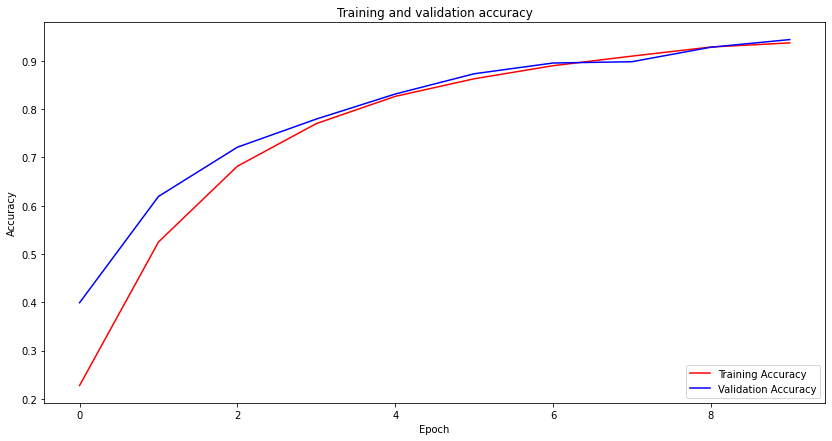

In [7]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

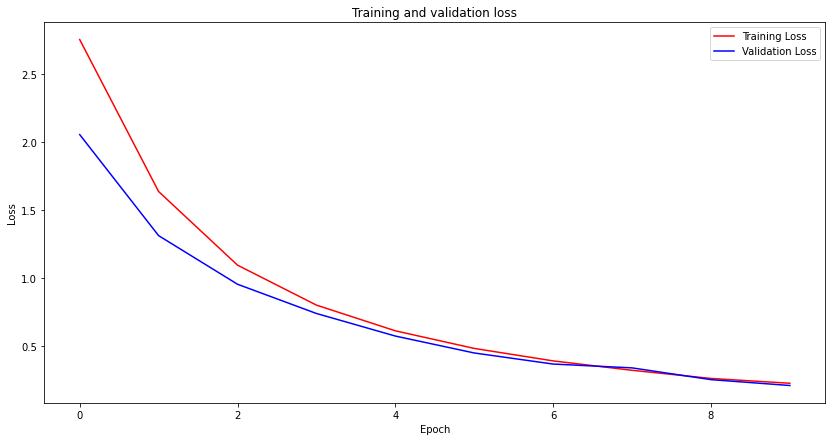

In [8]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [9]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 43s 633ms/step
              precision    recall  f1-score   support

           A       0.90      0.96      0.93       300
           B       0.95      0.96      0.96       300
           C       0.99      0.98      0.98       300
           D       0.96      0.96      0.96       300
           E       0.95      0.87      0.91       300
           F       0.97      0.98      0.98       300
           G       0.99      0.99      0.99       300
           H       0.98      0.99      0.98       300
           I       0.94      0.97      0.95       300
           J       0.99      0.95      0.97       300
           K       0.97      0.93      0.95       300
           L       0.96      0.99      0.98       300
           M       0.84      0.93      0.88       300
           N       0.96      0.87      0.91       300
           O       0.94      0.96      0.95       300
           P       0.99      0.95      0.97       300
           Q       0.94  

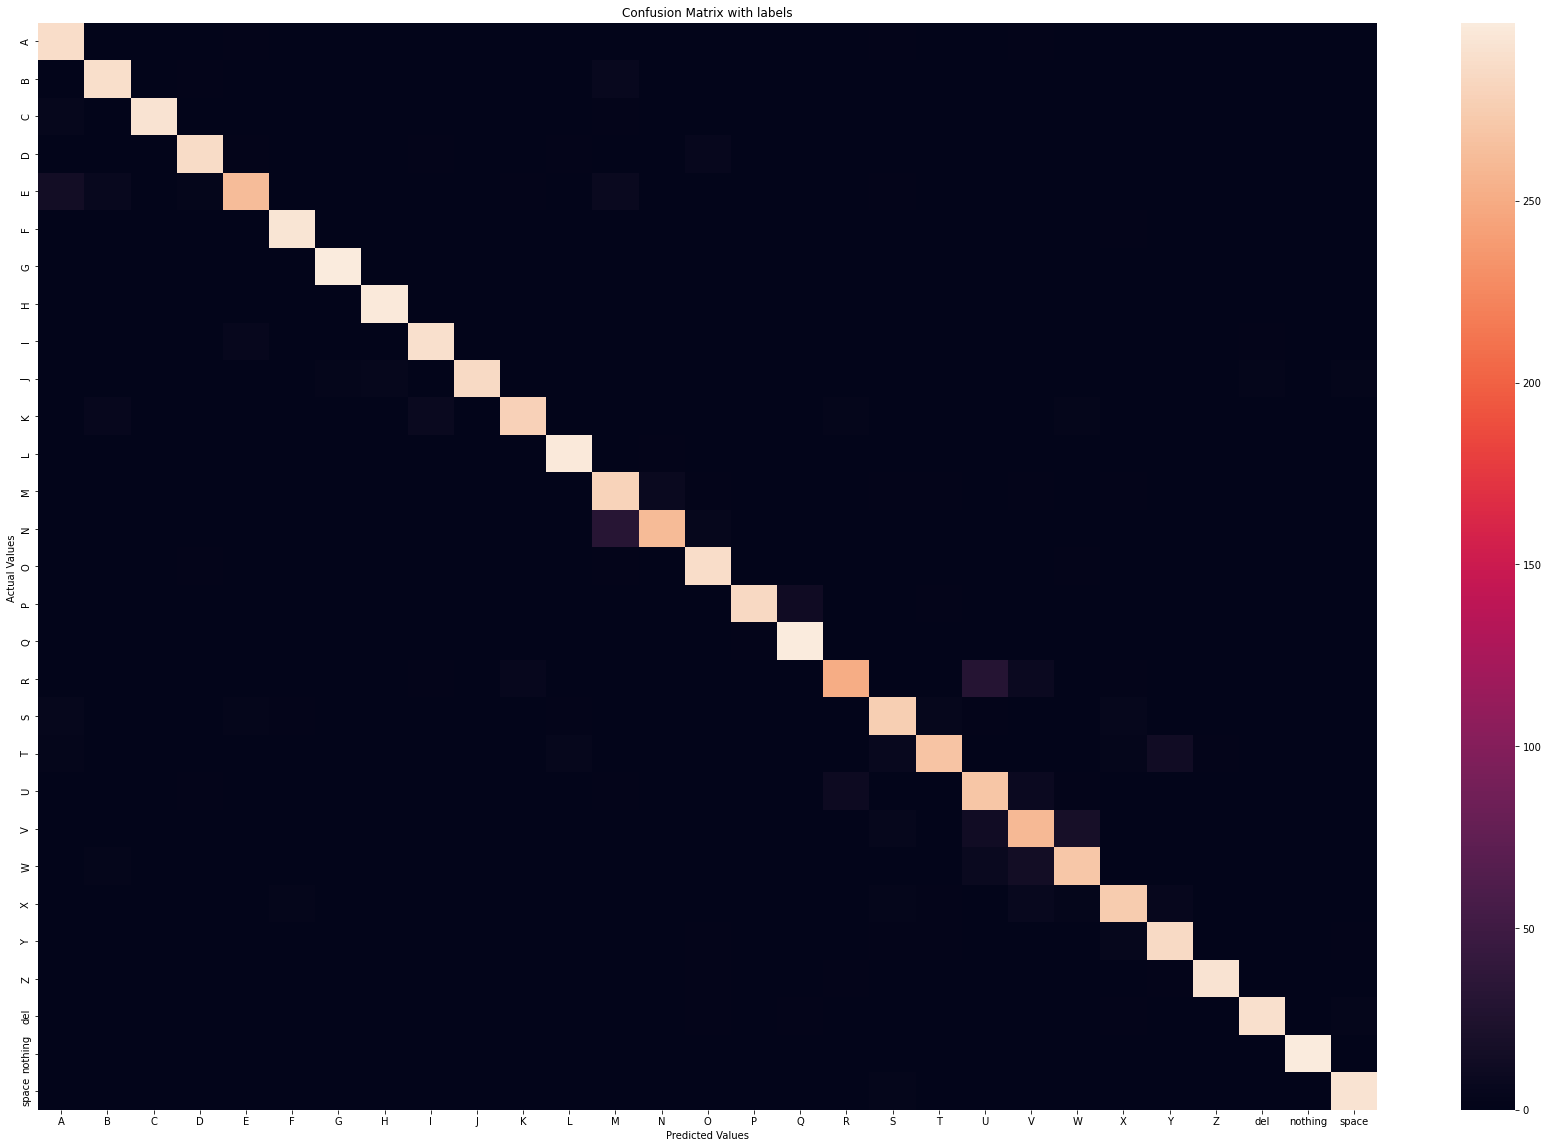

In [10]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [11]:
model.save('CNN.h5')

In [12]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[288   0   0   0   2   0   0   0   1   0   0   0   1   0   0   0   0   0
    2   0   0   2   0   1   1   1   1   0   0]
 [  0 289   0   2   0   0   0   0   1   0   0   0   7   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0]
 [  4   0 293   1   0   0   0   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   1 287   2   0   0   0   2   0   0   2   0   0   5   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [ 15   6   0   3 262   0   0   0   1   0   2   0   8   0   0   0   0   0
    2   0   0   1   0   0   0   0   0   0   0]
 [  1   0   0   0   0 294   0   0   1   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   2   1   0   0   0   0]
 [  0   0   0   0   0   0 298   1   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 297   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   1   1]
 [  0   0   0 

<AxesSubplot:>

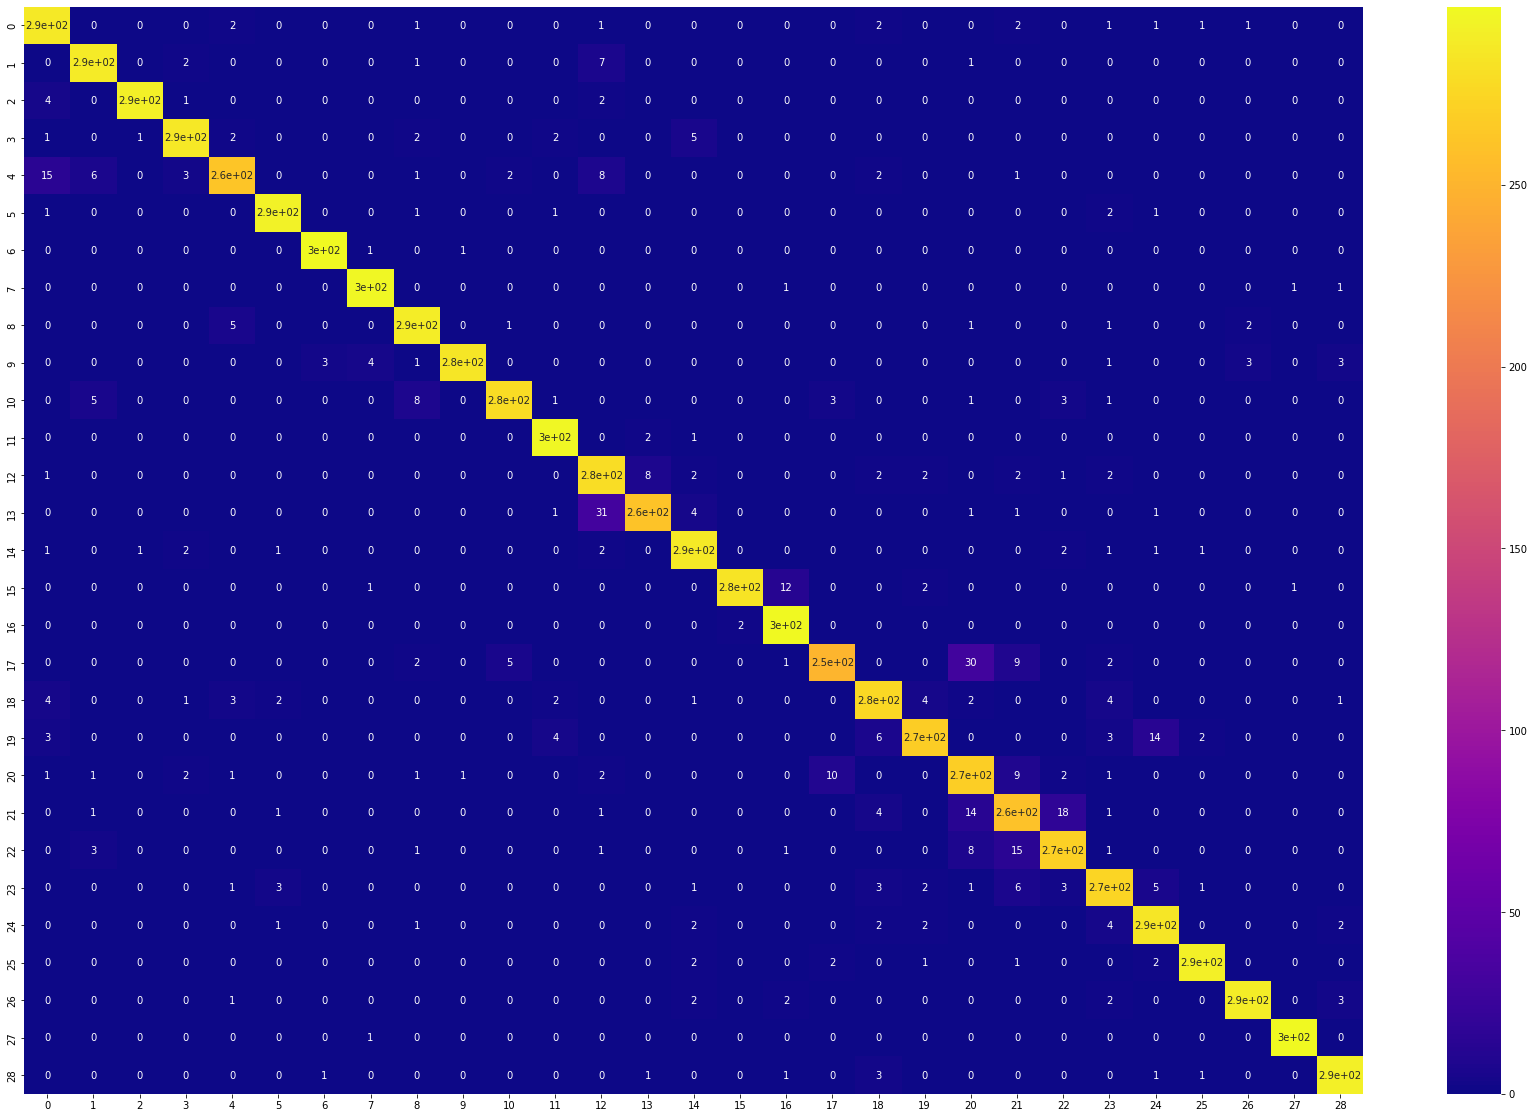

In [13]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)